In [1]:
import torch
import sklearn
import numpy as np
import pandas as pd
from torch import nn
import matplotlib.pyplot as plt

# Creating Data

In [2]:
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

__making a dataframe of data__

In [4]:
circles = pd.DataFrame({"X1": X[:, 0], "X2" : X[:, 1], "y" : y[:]})
circles.head()

,X1,X2,y
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


__visualize the data__

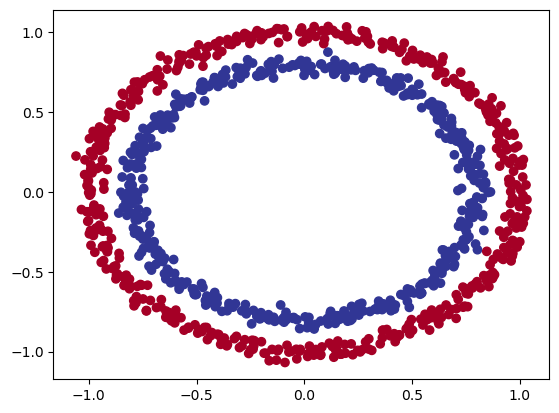

In [5]:
plt.scatter(x=circles["X1"], y=circles["X2"], c=y, cmap=plt.cm.RdYlBu);

__Convert To Tensors__

In [6]:
type(X) # currently is np.array()

numpy.ndarray

In [7]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

__Train, Test Split__

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

# Build A Model

In [10]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [11]:
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # creating 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        
    
    def forward(self, x):
        return self.layer_2(self.layer_1(x))

In [12]:
# creating an instance
model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
# since this is a very simple model we can replicate the above 2 layers with Sequential
model_1 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model_1.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.0956, -0.2761],
                      [ 0.5279, -0.5535],
                      [ 0.2599,  0.6628],
                      [ 0.5456,  0.3249],
                      [-0.6171,  0.2609]], device='mps:0')),
             ('0.bias',
              tensor([ 0.0579, -0.6610, -0.1719, -0.0493,  0.5504], device='mps:0')),
             ('1.weight',
              tensor([[-0.1142, -0.1090,  0.0291, -0.3148,  0.3952]], device='mps:0')),
             ('1.bias', tensor([0.4276], device='mps:0'))])

In [15]:
# make predictions with untrained model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
    
print(f"Length Of Predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 Predictions: \n {untrained_preds[:10]}")
print(f"\nFirst 10 Labels:\n {y_test[:10]}")

Length Of Predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 Predictions: 
 tensor([[-0.1838],
        [-0.2316],
        [-0.0724],
        [-0.2153],
        [-0.0944],
        [-0.1234],
        [-0.2406],
        [-0.2153],
        [-0.0716],
        [-0.2350]], device='mps:0')

First 10 Labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


The outputs of the predictions are raw __logits__ we have to convert them into probabilities then to labels. <br>
For our prediction probability values, we need to perform a range-style rounding on them <br>
* if `y_pred_probs >= 0.5` then label = 1 <br>
* if `y_pred_probs < 0.5` then label = 0

In [16]:
y_pred_probs = torch.sigmoid(untrained_preds)
print(f"First 5 Probabilites: \n {y_pred_probs[:5]}")

# now for labels we just have to round them
y_pred_labels = torch.round(y_pred_probs)
print(f"First 5 pred labels: \n {y_pred_labels[:5]}")

First 5 Probabilites: 
 tensor([[0.4542],
        [0.4424],
        [0.4819],
        [0.4464],
        [0.4764]], device='mps:0')
First 5 pred labels: 
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='mps:0')


__Setting up Loss fn and Optimizer__ <br>
<br>
For Binary Classification Problem we use: <br>
`BCELoss` : __https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html__ <br>
`BCELossWithLogitsLoss` : __https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html__

In [17]:
# setting up loss function
# loss_fn = nn.BCELoss() # this we have to pass the input through the sigmoid manually
loss_fn = nn.BCEWithLogitsLoss() # this have sigmoid activation function built in 

# setting up optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [18]:
# calculating accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

__training loop__

In [19]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):    
    model_1.train()
    
    # forward pass
    y_logits = model_1(X_train.to(device)).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_probs)
    
    # calc loss, accuracy
    loss = loss_fn(y_logits, y_train) # as BCEWithLogitsLoss() have sigmoid built in
    acc = accuracy_fn(y_train, y_preds)
    
    # optimizer zero grad
    optimizer.zero_grad()
    
    # loss backwards (back propagation)
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    if(epoch % 10 == 0):
        print(f"Epoch: {epoch}\tLoss: {loss}\t Acc: {acc}")

Epoch: 0	Loss: 0.7680045962333679	 Acc: 50.0
Epoch: 10	Loss: 0.7210360765457153	 Acc: 50.0
Epoch: 20	Loss: 0.7039915323257446	 Acc: 50.125
Epoch: 30	Loss: 0.6976650953292847	 Acc: 57.875
Epoch: 40	Loss: 0.6952529549598694	 Acc: 52.125
Epoch: 50	Loss: 0.6942834854125977	 Acc: 51.37500000000001
Epoch: 60	Loss: 0.6938534379005432	 Acc: 50.74999999999999
Epoch: 70	Loss: 0.6936321258544922	 Acc: 50.5
Epoch: 80	Loss: 0.6934972405433655	 Acc: 50.24999999999999
Epoch: 90	Loss: 0.6934028267860413	 Acc: 49.875


__testing loop__

In [20]:
model_1.eval()
with torch.inference_mode():
    # forward pass
    test_logits = model_1(X_test).squeeze()
    test_probs = torch.sigmoid(test_logits)
    test_preds = torch.round(test_probs)
    
    # calc test loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)
    
    print(f"Test Loss: {test_loss}\t Test Acc: {test_acc}")

Test Loss: 0.6931062340736389	 Test Acc: 49.5


Here we have a problem with the model, it's accuracy < 50, so the model is not learning much. <br>
To view the decision bounary we will import the `plot_decision_boundary()` from the github.

In [21]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/pratik-kadlak/Pytorch/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
        
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


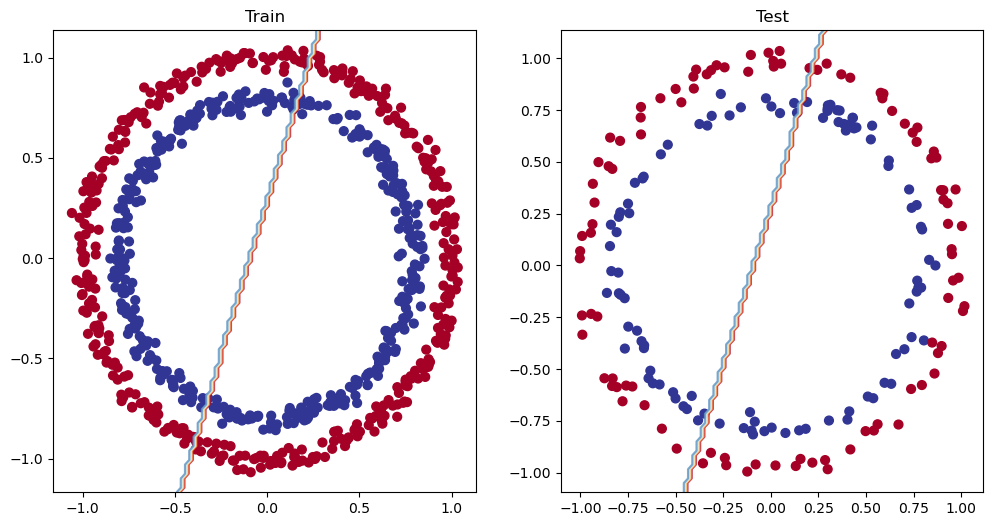

In [22]:
# plotting decision boundaries of the model
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

__Improving The Model__
* Add more layers
* Add more hidden units
* Train for longer
* Change Activation Functions
* Change the learning rate
* Change the loss function

Making a more complex model with more layers and more hidden units

In [23]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features= 2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
        # x = self.layer_1(x)
        # x = self.layer_2(x)
        # x = self.layer_3(x)

In [24]:
model_2 = CircleModelV1().to(device)
model_2

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [25]:
# setting up loss function
loss_fn = nn.BCEWithLogitsLoss()

# settign up optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [26]:
# writing a training and testing loop for model_2

torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_2.train()
    
    # forward pass
    y_logits = model_2(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_probs)
    
    # calc loss, acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)
    
    # optimizer zero grad
    optimizer.zero_grad()
    
    # loss backwards
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch}\tLoss: {loss}\tAcc: {acc}")

Epoch: 0	Loss: 0.6939550042152405	Acc: 50.875
Epoch: 100	Loss: 0.6930477619171143	Acc: 50.375
Epoch: 200	Loss: 0.6929859519004822	Acc: 51.125
Epoch: 300	Loss: 0.6929804682731628	Acc: 51.625
Epoch: 400	Loss: 0.6929798722267151	Acc: 51.125
Epoch: 500	Loss: 0.6929798722267151	Acc: 51.0
Epoch: 600	Loss: 0.6929798722267151	Acc: 51.0
Epoch: 700	Loss: 0.6929798126220703	Acc: 51.0
Epoch: 800	Loss: 0.6929798722267151	Acc: 51.0
Epoch: 900	Loss: 0.6929798722267151	Acc: 51.0


In [27]:
# testing
model_2.eval()
with torch.inference_mode():
    # forward pass
    test_logits = model_2(X_test).squeeze()
    test_probs = torch.sigmoid(test_logits)
    test_preds = torch.round(test_probs)
    
    # calc loss, acc
    loss = loss_fn(test_logits, y_test)
    acc = accuracy_fn(y_test, test_preds)
    
    print(f"Loss: {loss}\tAcc: {acc}")

Loss: 0.6946794986724854	Acc: 46.0


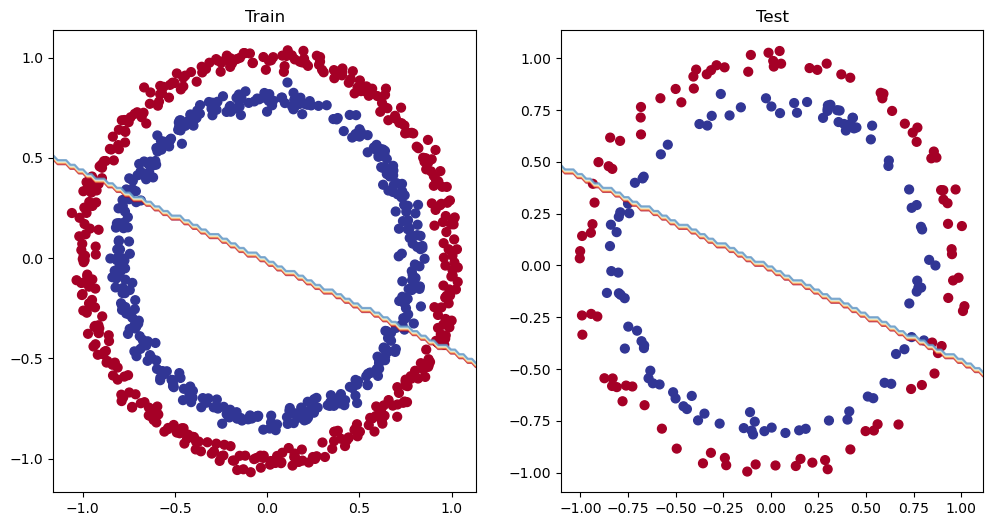

In [28]:
# plotting decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

Again the model has not learnt anything useful, despite the increase in number of layers, hidden units and number of epochs. <br> To check if the model is learning anything we will try to fit a straight line through a linearly separable data

In [29]:
# creating a linearyly separable data
weight = 0.7
bias = 0.3

# create data
X_regression = torch.arange(start=0, end=1, step=0.01).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y_regression[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [30]:
# create train and test split
train_split = int(0.8 * len(X_regression))
X_train_reg, y_train_reg = X_regression[:train_split], y_regression[:train_split]
X_test_reg, y_test_reg = X_regression[train_split:], y_regression[train_split:]

len(X_train_reg), len(y_train_reg), len(X_test_reg), len(y_test_reg)

(80, 80, 20, 20)

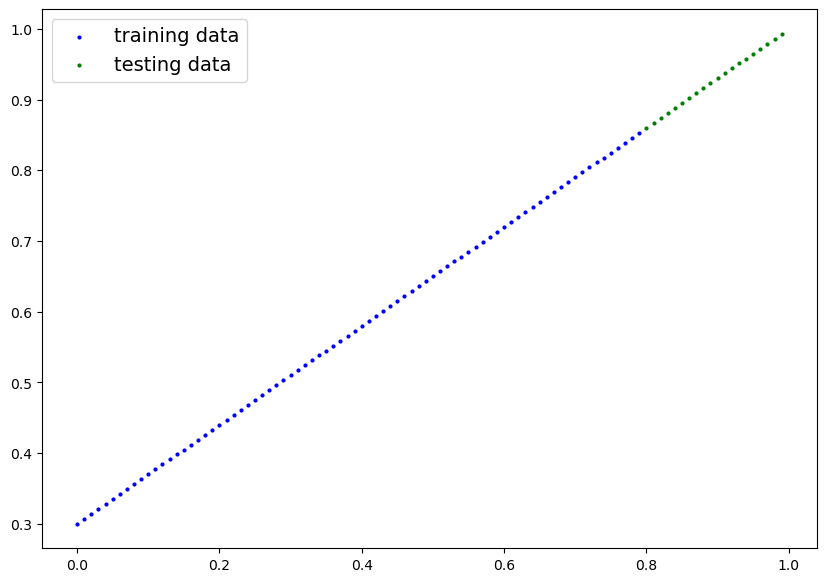

In [31]:
# lets plot the data
plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg)

In [32]:
# adjusting model_2 for the new data just changed the in_feature to 1 

model_3 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10), 
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
)

In [33]:
# trainin loop

torch.manual_seed(42)
torch.mps.manual_seed(42)

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

epochs = 1000


model_3 = model_3.to(device)
X_train_reg, y_train_reg = X_train_reg.to(device), y_train_reg.to(device)
X_test_reg, y_test_reg = X_test_reg.to(device), y_test_reg.to(device)

for epoch in range(epochs):
    model_3.train()
    
    # forward pass
    y_preds = model_3(X_train_reg);
    
    # calc loss
    loss = loss_fn(y_preds, y_train_reg)
    
    # optimizer zero grad
    optimizer.zero_grad()
    
    # loss backwards
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    if epoch%100==0:
        print(f"Epoch: {epoch}\tLoss: {loss}")

Epoch: 0	Loss: 0.5854212641716003
Epoch: 100	Loss: 5.773441102974175e-07
Epoch: 200	Loss: 2.093079043419266e-10
Epoch: 300	Loss: 1.602162819731509e-13
Epoch: 400	Loss: 3.34066101333446e-14
Epoch: 500	Loss: 1.880717905358969e-14
Epoch: 600	Loss: 1.957323226295469e-14
Epoch: 700	Loss: 1.7708057242771247e-14
Epoch: 800	Loss: 1.624256318907922e-14
Epoch: 900	Loss: 1.560973640385606e-14


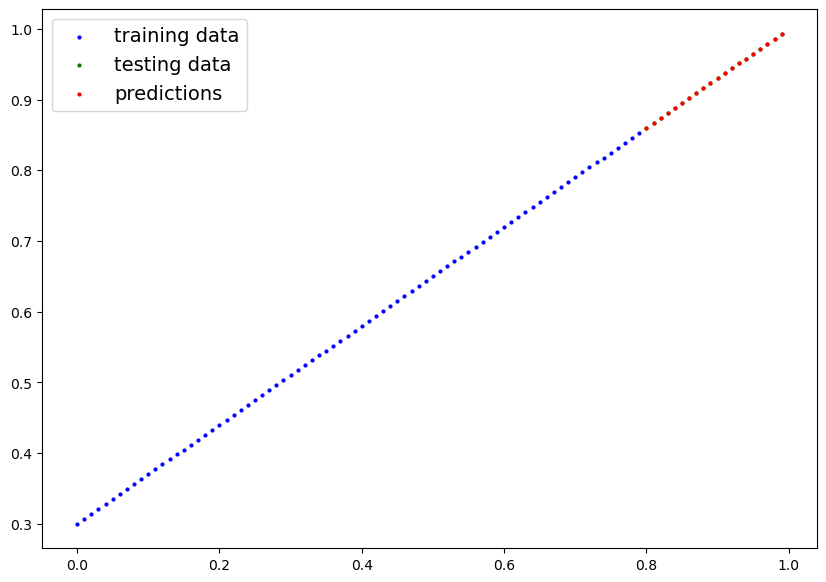

In [34]:
# model_3 on test data

model_3.eval()
with torch.inference_mode():
    test_preds = model_3(X_test_reg)

X_train_reg = X_train_reg.cpu()
y_train_reg = y_train_reg.cpu()
X_test_reg = X_test_reg.cpu()
y_test_reg = y_test_reg.cpu()
test_preds = test_preds.cpu()

# plotting prediciton
plot_predictions(X_train_reg, y_train_reg, X_test_reg, y_test_reg, test_preds)

The predictions are prefect for linearly separable data so our model is learning something. <br> The missing piece is non linearity, because the data we are working with (circles) is non linearly separable and we are just using linear layers to solve them.

In [35]:
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=16)
        self.layer_2 = nn.Linear(in_features=16, out_features=16)
        self.layer_3 = nn.Linear(in_features=16, out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.layer_1(x)) # passing output of linear_layers through non linear activation functions  
        x = self.relu(self.layer_2(x)) # passing output of linear_layers through non linear activation functions 
        return self.layer_3(x)

In [36]:
model_4 = CircleModelV3().to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_4.parameters(), lr=0.1)

# writing a training and testing loop for model_4

torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    model_4.train()
    
    # forward pass
    y_logits = model_4(X_train).squeeze()
    y_probs = torch.sigmoid(y_logits)
    y_preds = torch.round(y_probs)
    
    # calc loss, acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_preds)
    
    # optimizer zero grad
    optimizer.zero_grad()
    
    # loss backwards
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    if epoch%100 == 0:
        print(f"Epoch: {epoch}\tLoss: {loss}\tAcc: {acc}")

Epoch: 0	Loss: 0.697527289390564	Acc: 50.0
Epoch: 100	Loss: 0.6898747086524963	Acc: 56.25
Epoch: 200	Loss: 0.6866254806518555	Acc: 52.87500000000001
Epoch: 300	Loss: 0.6826397776603699	Acc: 53.625
Epoch: 400	Loss: 0.677353024482727	Acc: 54.0
Epoch: 500	Loss: 0.670059859752655	Acc: 56.00000000000001
Epoch: 600	Loss: 0.659384548664093	Acc: 62.375
Epoch: 700	Loss: 0.6416844725608826	Acc: 75.5
Epoch: 800	Loss: 0.6128420233726501	Acc: 87.375
Epoch: 900	Loss: 0.5639762878417969	Acc: 97.25


In [37]:
# evaluate on test data
model_4.eval()
with torch.inference_mode():
    # forward pass
    test_logits = model_4(X_test).squeeze()
    test_probs = torch.sigmoid(test_logits)
    test_preds = torch.round(test_probs)
    
    # calc loss, acc
    loss = loss_fn(test_logits, y_test)
    acc = accuracy_fn(y_test, test_preds)
    
print(f"Loss: {loss}\t Acc: {acc}")

Loss: 0.517879068851471	 Acc: 97.0


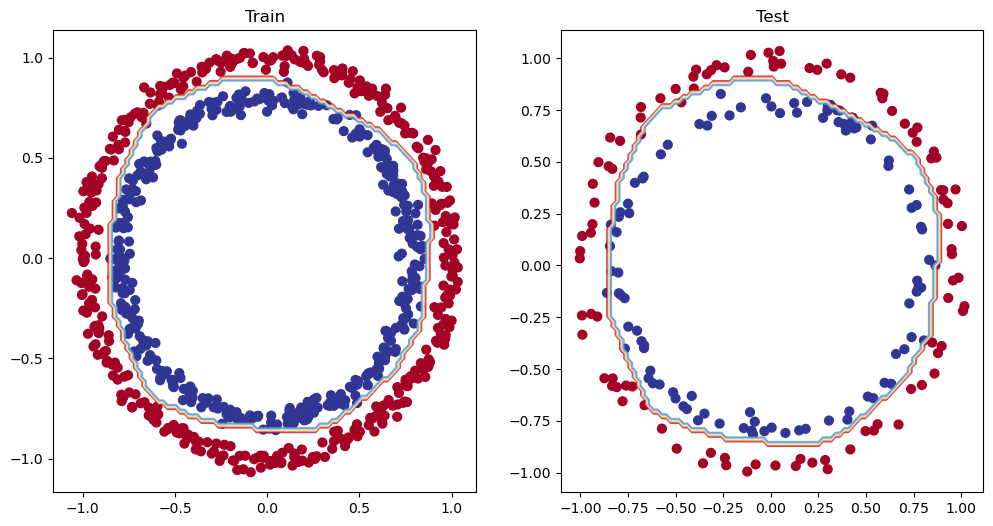

In [38]:
# plotting decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)

# Multi-Class Classification

__Creating Data__

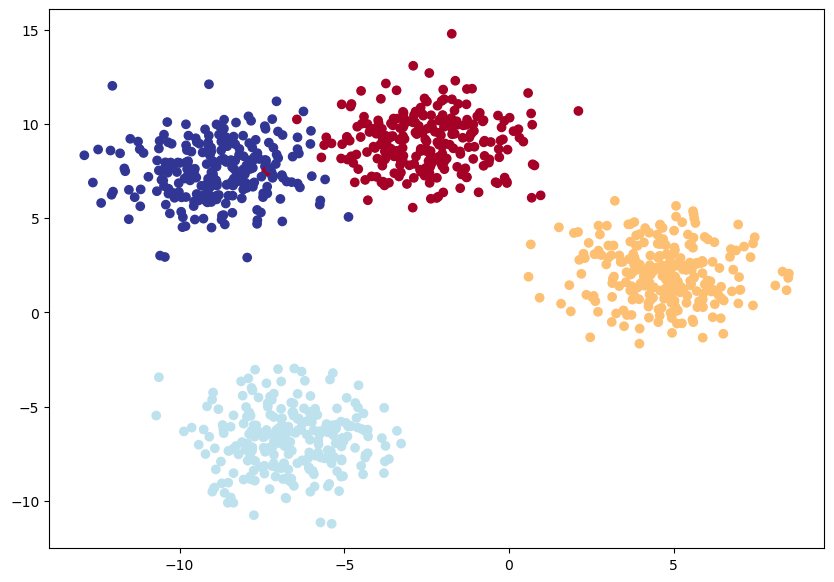

In [39]:
from sklearn.datasets import make_blobs

# set hyperparameters 
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# creating data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# train test split
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, 
                                                                        y_blob, 
                                                                        test_size=0.2, 
                                                                        random_state=RANDOM_SEED)

# plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[: ,1], c=y_blob, cmap=plt.cm.RdYlBu)

__Building MultiClass Classification Models__

In [40]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

In [41]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
        
    def forward(self, x):
        return self.linear_layer_stack(x)

In [42]:
# creating instance
model_5 = BlobModel(input_features=2, output_features=4).to(device)
model_5

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [43]:
# setting up loss func
loss_fn = nn.CrossEntropyLoss()

# setting up optimizer
optimizer = torch.optim.SGD(params=model_5.parameters(), lr=0.1)

In [44]:
# getting data on the same device as model
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

In [45]:
# lets view the output of the model
model_5.eval()
with torch.inference_mode():
    y_preds = model_5(X_blob_test)
    
y_preds[:5]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')

We want the output to be a number, ie label for one of the 4 class, So we have to turn these raw logits into probabilites and then classify the instance as the label which have the highest probability

In [46]:
y_probs = torch.softmax(y_preds[:5], dim=1)
y_probs

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='mps:0')

In [47]:
y_preds = torch.argmax(y_probs, dim=1)
y_preds # now the output is same as we wanted

tensor([1, 0, 0, 0, 0], device='mps:0')

__training loop__

In [48]:
torch.manual_seed(42)
torch.mps.manual_seed(42)

epochs = 100

for epoch in range(epochs):
    model_5.train()
    
    # forward pass
    y_logits = model_5(X_blob_train)
    y_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_probs, dim=1)
    
    # calc loss, acc
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_blob_train, y_preds)
    
    # optimizer zero grad
    optimizer.zero_grad()
    
    # loss backwards
    loss.backward()
    
    # optimizer step
    optimizer.step()
    
    if(epoch%10 == 0):
        print(f"Epoch: {epoch} \t Loss: {loss} \t Acc: {acc}")

Epoch: 0 	 Loss: 1.1588265895843506 	 Acc: 40.375
Epoch: 10 	 Loss: 0.6447553038597107 	 Acc: 96.75
Epoch: 20 	 Loss: 0.42535150051116943 	 Acc: 98.5
Epoch: 30 	 Loss: 0.25294238328933716 	 Acc: 99.125
Epoch: 40 	 Loss: 0.11232152581214905 	 Acc: 99.25
Epoch: 50 	 Loss: 0.06626509875059128 	 Acc: 99.25
Epoch: 60 	 Loss: 0.050680141896009445 	 Acc: 99.25
Epoch: 70 	 Loss: 0.04299674183130264 	 Acc: 99.25
Epoch: 80 	 Loss: 0.03836136683821678 	 Acc: 99.25
Epoch: 90 	 Loss: 0.03524841368198395 	 Acc: 99.25


In [49]:
# evaluating the model on test data
model_5.eval()
with torch.inference_mode():
    # forward pass
    test_logits = model_5(X_blob_test)
    test_probs = torch.softmax(test_logits, dim=1)
    test_preds = torch.argmax(test_probs, dim=1)
    
    # calc loss, acc
    loss = loss_fn(test_logits, y_blob_test)
    acc = accuracy_fn(y_blob_test, test_preds)
    
print(f"Test Loss: {loss} \t Test Acc: {acc}")

Test Loss: 0.02453026734292507 	 Test Acc: 99.5


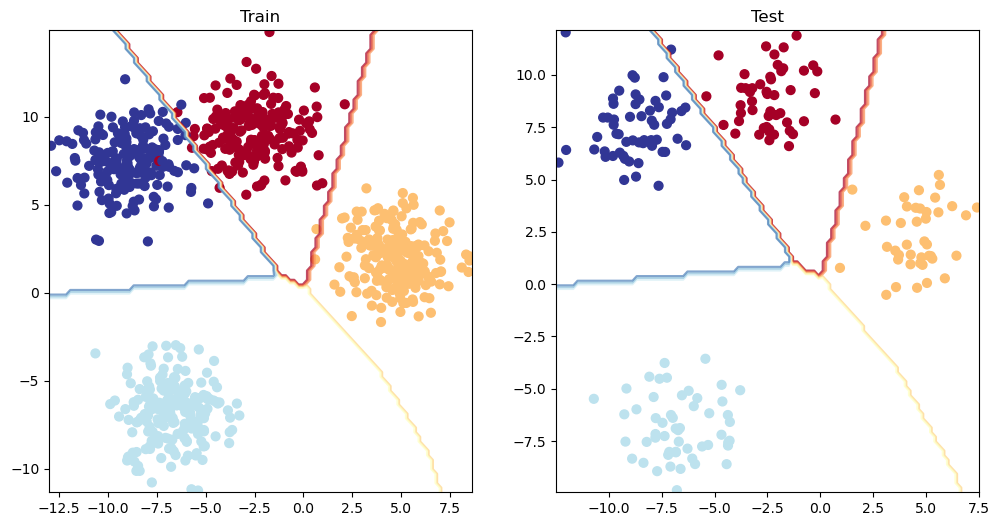

In [50]:
# plotting decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_5, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_5, X_blob_test, y_blob_test)